# HW5 SVM and Kernel Methods -- Part 2 Kernel Regression

In this part of HW5, you will solve a regression problem with kernel regression. It allows you to:

* gain experience with kernel regression, and
* perform model selection with hyperparameters in both a regression model  and its kernel.


## Import relevant packages

In [44]:
import numpy as np
import pandas as pd
import os

# Plotting utils
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

## Load Training set data for the 'ByYear' split

In [45]:
# load the data
DATA_DIR = os.path.join("data_melbourne_daily_min_temp/") #TODO: fix it to your local file structure if necessary
data_trByYear_df = pd.read_csv(os.path.join(DATA_DIR, 'data_train_ByYear.csv'))

# Inspect the first part of the data
data_trByYear_df.head()

date  years_since_19850101  temp_deg_C
0  1981-01-01                 -4.00        20.7
1  1981-01-02                 -4.00        17.9
2  1981-01-03                 -4.00        18.8
3  1981-01-04                 -3.99        14.6
4  1981-01-05                 -3.99        15.8

In [8]:
# Inspect the last part of the data
data_trByYear_df.tail()

date  years_since_19850101  temp_deg_C
2185  1986-12-27              1.986301        14.6
2186  1986-12-28              1.989041        14.2
2187  1986-12-29              1.991781        13.2
2188  1986-12-30              1.994521        11.7
2189  1986-12-31              1.997260        17.2

In [11]:
# Read relevant columns into numpy arrays for x and y. 
# NOTE: we only have 1 feature in this dataset. 

x_train = data_trByYear_df['years_since_19850101'].values[:][:,np.newaxis].copy()
y_train = data_trByYear_df['temp_deg_C'].values[:].copy()

print("Training data (ByYear split strategy)")
print("x_train.shape: %s" % str(x_train.shape))
print("y_train.shape : %s" % str(y_train.shape))
print("mean(y_train) : %.3f" % np.mean(y_train))

Training data (ByYear split strategy)
x_train.shape: (2190, 1)
y_train.shape : (2190,)
mean(y_train) : 11.003


## Load Validation set data for the 'ByYear' split

In [13]:
data_vaByYear_df = pd.read_csv(os.path.join(DATA_DIR, 'data_valid_ByYear.csv'))
data_vaByYear_df.head()

date  years_since_19850101  temp_deg_C
0  1987-01-01              2.000000        12.3
1  1987-01-02              2.002740        13.8
2  1987-01-03              2.005479        15.3
3  1987-01-04              2.008219        15.6
4  1987-01-05              2.010959        16.2

In [14]:
x_valid = data_vaByYear_df['years_since_19850101'].values[:][:,np.newaxis].copy()
y_valid = data_vaByYear_df['temp_deg_C'].values[:].copy()

print("Validation data (ByYear split strategy)")
print("x_valid.shape: %s" % str(x_valid.shape))
print("y_valid.shape : %s" % str(y_valid.shape))
print("mean(y_valid) : %.3f" % np.mean(y_valid))

Validation data (ByYear split strategy)
x_valid.shape: (730, 1)
y_valid.shape : (730,)
mean(y_valid) : 11.413


## Plot both training and validation sets

In the plot below, temperatures (labels) are plot against time (the only feature). This is a hard problem for many learning models that have no sense of the periodicity. 

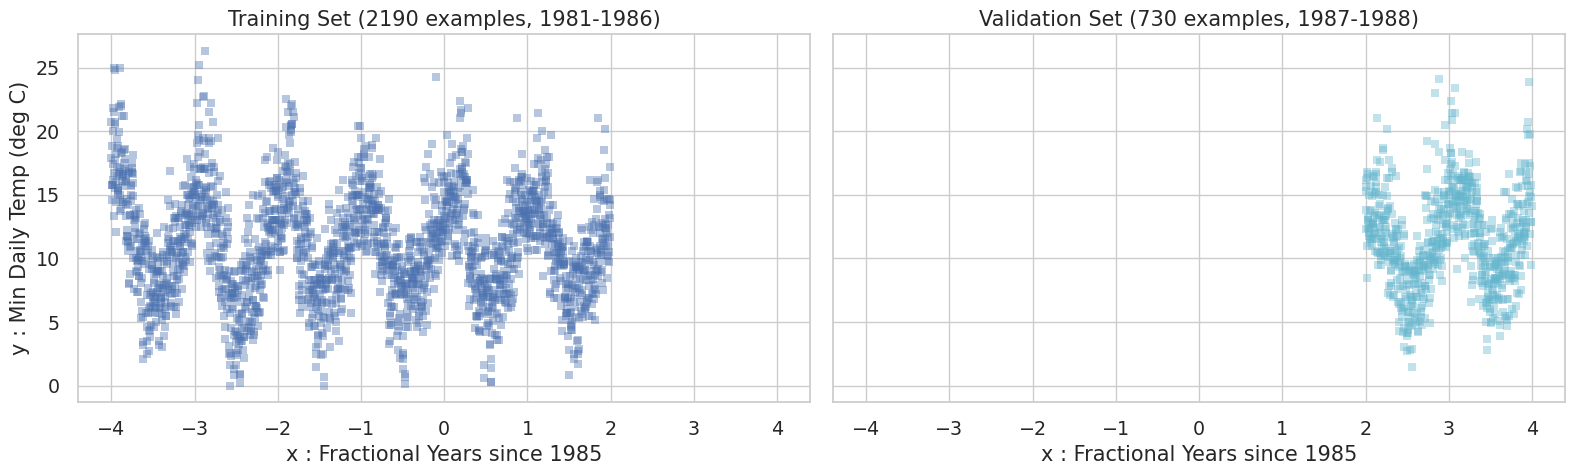

In [17]:
fig, axgrid = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16,5))

axgrid[0].plot(x_train, y_train, 'bs', alpha=0.4)
axgrid[0].set_xlabel('x : Fractional Years since 1985');
axgrid[0].set_title('Training Set (%d examples, %s-%s)' % (
    y_trByYear_N.size,
    pd.to_datetime(data_trByYear_df['date'].values[0]).year,
    pd.to_datetime(data_trByYear_df['date'].values[-1]).year))

axgrid[1].plot(x_valid, y_valid, 'cs', alpha=0.4)
axgrid[1].set_xlabel('x : Fractional Years since 1985');
axgrid[1].set_title('Validation Set (%d examples, %s-%s)' % (
    y_valid.size,
    pd.to_datetime(data_vaByYear_df['date'].values[0]).year,
    pd.to_datetime(data_vaByYear_df['date'].values[-1]).year))

axgrid[0].set_ylabel("y : Min Daily Temp (deg C)");
plt.tight_layout();

## Prepare to use sklearn splitter tools for hyperparameter search

In [18]:
x_all = np.vstack([x_train, x_valid])
y_all = np.hstack([y_train, y_valid])

In [23]:
# Create splitter object using Predefined Split
import sklearn.model_selection

byyear_splitter = sklearn.model_selection.PredefinedSplit(np.hstack([
    -1 * np.ones(y_train.size), # -1 means never include this example in any 'test' split for grid search
    0  * np.ones(y_valid.size), #  0 means include in the first test split (we count starting at 0 in python)
    ]))

## Define utility function to make pretty plots of predictions for each model

In [34]:
def plot_data_and_predictions(model, model_legend_text='INSERT YOUR TEXT HERE'):
    plt.plot(x_train, y_train, 'bs', alpha=0.4, label='train data');
    plt.plot(x_valid, y_valid, 'cs', alpha=0.4, label='valid data');

    x_test_2 = [x_valid.min() + 2, x_valid.max() + 2]
    plt.fill_between(x_test_2, 0, 30, color='y', alpha=0.2, label='test period')

    L = 101
    xgrid_L1 = np.linspace(-5, 6, L).reshape((L,1))
    plt.plot(xgrid_L1, model.predict(xgrid_L1), 'r-', linewidth=3, label=model_legend_text);

    plt.ylim([-2, 28]);
    plt.xlabel('Fractional Years since 1985');
    plt.ylabel("Min Daily Temp (deg C)");
    plt.legend(bbox_to_anchor=(1.0, 0.5));



## Question 6 (5 points): Ridge Regression

**Question 6 (5 points)**: In this question, you need to fit a Ridge Regression model. In particular, you need to run model selection with `GridSearchCV`. NOTE that we aim to minimize the mean squared error, and the search should evalue models correspondingly. Once you have trained the best model, please generate a plot like the one below but using your best model. **In your report, please include best hyperparameter combination found and your generated plot**. 

The best hyperparameter setting found is:
{'alpha': 0.01, 'kernel': ExpSineSquared(length_scale=1.79, periodicity=0.157)}


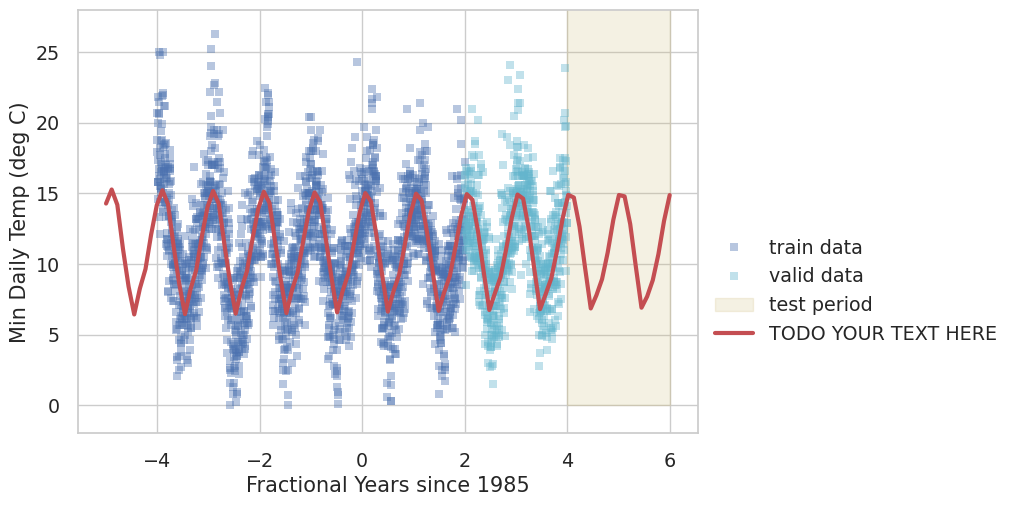

In [60]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import ExpSineSquared

# Recommended search range of alpha
alpha=[0.01, 0.1, 1, 10, 100]

kr = KernelRidge(alpha=1.0, kernel="linear")

# TODO: the following code is broken. Please fix the code to create a plot like the one below. 
# NOTE: It takes time to do the search. You can set `verbose=10` to monitor the progress.  
kr_linear_gs = sklearn.model_selection.GridSearchCV(
    kr, 
    param_grid=??,
    scoring=??, # <https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter>
    cv=my_ByYear_splitter,
    return_train_score=True,
    refit=??) 

print("The best hyperparameter setting found is:")
print(kr_linear_gs.best_params_)

# Plot the best model
kr_linear_best = kr_linear_gs.best_estimator_
plot_data_and_predictions(kr_linear_best, 'TODO YOUR TEXT HERE')

## Question 7 (5 points): Kernel Regression with the RBF Kernel

**Question 7 (5 points)**: In this question, you need to fit a Kernel Regression model with the RBF kernel. You need to run model selection with `GridSearchCV`. Again we aim to minimize the mean squared error, so please perform the search correspondingly. Once you have trained the best model, please generate a plot like the one above but using your best model. **In your report, please include best hyperparameter combination found and your generated plot**. 

The best hyperparameter setting found is:
{'alpha': 0.01, 'kernel': RBF(length_scale=16)}


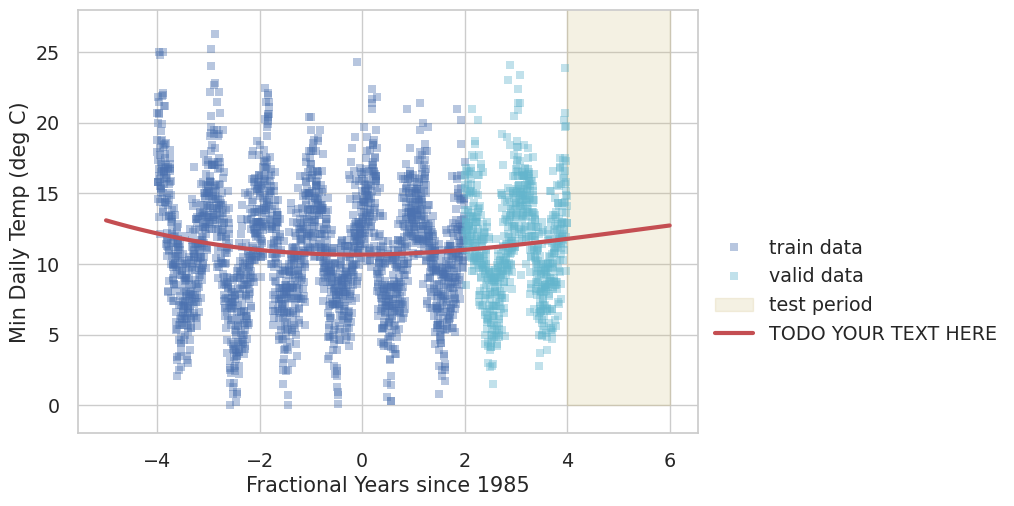

In [37]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.gaussian_process.kernels import RBF

# Recommended search range of alpha
alphas=[0.01, 0.1, 1, 10, 100]

# NOTE: RBF is implemented within kernel regression and has a parameter gamma. It can be tuned by just 
# specify a list of possible gamma values. However, this time I use an external kernel to 
# to show how we can tune any kernels. 

# NOTE: the implementation sklearn.gaussian_process.kernels.RBF uses `length_scale` to 
# parameterize an RBF kernel. It is equivalent to the gamma parameterization: 
# gamma = 1/(2 * length_scale^2)

length_scales = [1, 2, 4, 8, 16, 32, 64]
kernels = [RBF(length_scale) for length_scale in length_scales]


kr = KernelRidge(alpha=1.0, kernel="linear")

# TODO: the following code is broken. Please fix the code to create a plot like the one below. 
# NOTE: It takes time to do the search. You can set `verbose=10` to monitor the progress.  
kr_rbf_gs = sklearn.model_selection.GridSearchCV(
    kr, 
    param_grid=dict(alpha=alphas, kernel=kernels), # set the range of the hyperparameter search
    scoring="neg_mean_squared_error",
    cv=byyear_splitter,
    return_train_score=True,
    refit=??) 


print("The best hyperparameter setting found is:")
print(kr_rbf_gs.best_params_)

# Plot the best model
kr_rbf_best = kr_rbf_gs.best_estimator_
plot_data_and_predictions(kr_rbf_best, 'TODO YOUR TEXT HERE')

## Question 8 (5 points): Kernel Regression with a Periodic Kernel

**Question 8 (5 points)**: In this question, you need to fit a Kernel Regression model with a periodic kernel. You need to select hyperparameters in the KR and the kernel via `GridSearchCV`. Again we aim to minimize the mean squared error, so please perform the search correspondingly. Once you have trained the best model, please generate a plot like the one above but using your best model. **In your report, please include best hyperparameter combination found and your generated plot**. 

In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import ExpSineSquared

# Recommended search range of alpha
alpha=[0.01, 0.1, 1, 10, 100]

# TODO: please check the documentation of the ExpSineSquared kernel
# <https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html>
# There are two hyperparameters, length_scale and periodicity
# The length scale controls how much a data point focuses on its near neighbors. 
# The periodicity controls the frequency of similiarity along the distance. This 
# hyperparameter is critical to the performance of regression model on this dataset. 

# recommended hyperparameter range in the kernel. 
length_scales = [0.25, 0.5, 1, 2, 4]
periodicities = [0.1, 0.5, 1.0, 1.5, 2.0]

# TODO: please implement your own model tuning here. 




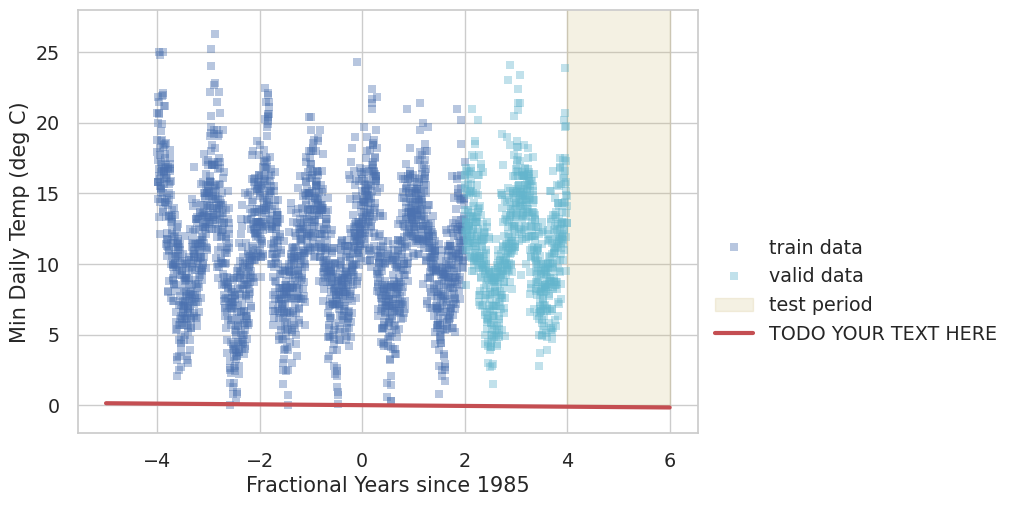

In [37]:
print("The best hyperparameter setting found is:")
print(kr_ess_gs.best_params_)

# Plot the best model
kr_ess_best = kr_ess_gs.best_estimator_
plot_data_and_predictions(model, 'TODO YOUR TEXT HERE')

In [ ]:
periodic_klr = sklearn.pipeline.Pipeline([
    ('periodicKernelTransformer', 
         sklearn.preprocessing.FunctionTransformer(identity_kernel)), #TODO: use periodic kernel
    ('ridgeRegressor', sklearn.linear_model.Ridge(alpha=1.0)),
    ])

### Setup grid search for periodic kernel

Don't need to change any values here!

In [ ]:
periodic_grid = [0.5, 1.0, 1.5, 2.0]
length_scale_grid = [0.01, 0.03, 0.09, 0.27]
alpha_grid = [1.0, 1000.0, 100000.0]

print("Possible Values for periodicKernelTransformer__kw_args['periodic']")
for period in periodic_grid:
    print("% 11.3f" % period)

print("Possible Values for periodicKernelTransformer__kw_args['length_scale']")
for length_scale in length_scale_grid:
    print("% 11.3f" % length_scale)

print("Possible Values for ridgeRegressor__alpha")
for alpha in alpha_grid:
    print("% 11.3f" % alpha)

Possible Values for periodicKernelTransformer__kw_args['periodic']
      0.500
      1.000
      1.500
      2.000
Possible Values for periodicKernelTransformer__kw_args['length_scale']
      0.010
      0.030
      0.090
      0.270
Possible Values for ridgeRegressor__alpha
      1.000
   1000.000
 100000.000


In [ ]:
periodic_param_grid_by_name = dict(
    periodicKernelTransformer__kw_args=[
        dict(length_scale=ell, period=p,
            x_train_NF=x_trByYear_N1) for (ell,p) in itertools.product(length_scale_grid, periodic_grid)],
    ridgeRegressor__alpha=alpha_grid,
    )

In [ ]:
periodic_klr_grid_searcher = sklearn.model_selection.GridSearchCV(
    periodic_klr,
    periodic_param_grid_by_name,
    scoring='neg_mean_squared_error',
    cv=my_ByYear_splitter,
    return_train_score=True,
    refit=False)

### Run grid search for 'period' and 'length_scale' and 'alpha' hyperparameters

In [ ]:
start_time_sec = time.time()
periodic_klr_grid_searcher.fit(x_all_ByYear_L1, y_all_ByYear_L)
elapsed_time_sec = time.time() - start_time_sec

# Build dataframe of results
periodic_klr_search_results_df = pd.DataFrame(periodic_klr_grid_searcher.cv_results_).copy()
print("Grid search of %3d configurations done after %6.1f sec" % (
    periodic_klr_search_results_df.shape[0], elapsed_time_sec))

Grid search of  48 configurations done after    0.1 sec


In [ ]:
pd.set_option('display.precision', 4)
param_keys = ['param_ridgeRegressor__alpha', 'param_periodicKernelTransformer__kw_args']
periodic_klr_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score', 'mean_fit_time']]

param_ridgeRegressor__alpha  \
0                          1.0   
1                       1000.0   
2                     100000.0   
3                          1.0   
4                       1000.0   
5                     100000.0   
6                          1.0   
7                       1000.0   
8                     100000.0   
9                          1.0   
10                      1000.0   
11                    100000.0   
12                         1.0   
13                      1000.0   
14                    100000.0   
15                         1.0   
16                      1000.0   
17                    100000.0   
18                         1.0   
19                      1000.0   
20                    100000.0   
21                         1.0   
22                      1000.0   
23                    100000.0   
24                         1.0   
25                      1000.0   
26                    100000.0   
27                         1.0   
28                      1000.0   
29                    100000.0   
30                         1.0   
31                      1000.0   
32                    100000.0   
33                         1.0   
34                      1000.0   
35                    100000.0   
36                         1.0   
37                      1000.0   
38                    100000.0   
39                         1.0   
40                      1000.0   
41                    100000.0   
42                         1.0   
43                      1000.0   
44                    100000.0   
45                         1.0   
46                      1000.0   
47                    100000.0   

             param_periodicKernelTransformer__kw_args  mean_train_score  \
0   {'length_scale': 0.01, 'period': 0.5, 'x_train...          -17.1946   
1   {'length_scale': 0.01, 'period': 0.5, 'x_train...          -17.1966   
2   {'length_scale': 0.01, 'period': 0.5, 'x_train...          -17.2955   
3   {'length_scale': 0.01, 'period': 1.0, 'x_train...          -17.1946   
4   {'length_scale': 0.01, 'period': 1.0, 'x_train...          -17.1966   
5   {'length_scale': 0.01, 'period': 1.0, 'x_train...          -17.2955   
6   {'length_scale': 0.01, 'period': 1.5, 'x_train...          -17.1946   
7   {'length_scale': 0.01, 'period': 1.5, 'x_train...          -17.1966   
8   {'length_scale': 0.01, 'period': 1.5, 'x_train...          -17.2955   
9   {'length_scale': 0.01, 'period': 2.0, 'x_train...          -17.1946   
10  {'length_scale': 0.01, 'period': 2.0, 'x_train...          -17.1966   
11  {'length_scale': 0.01, 'period': 2.0, 'x_train...          -17.2955   
12  {'length_scale': 0.03, 'period': 0.5, 'x_train...          -17.1946   
13  {'length_scale': 0.03, 'period': 0.5, 'x_train...          -17.1966   
14  {'length_scale': 0.03, 'period': 0.5, 'x_train...          -17.2955   
15  {'length_scale': 0.03, 'period': 1.0, 'x_train...          -17.1946   
16  {'length_scale': 0.03, 'period': 1.0, 'x_train...          -17.1966   
17  {'length_scale': 0.03, 'period': 1.0, 'x_train...          -17.2955   
18  {'length_scale': 0.03, 'period': 1.5, 'x_train...          -17.1946   
19  {'length_scale': 0.03, 'period': 1.5, 'x_train...          -17.1966   
20  {'length_scale': 0.03, 'period': 1.5, 'x_train...          -17.2955   
21  {'length_scale': 0.03, 'period': 2.0, 'x_train...          -17.1946   
22  {'length_scale': 0.03, 'period': 2.0, 'x_train...          -17.1966   
23  {'length_scale': 0.03, 'period': 2.0, 'x_train...          -17.2955   
24  {'length_scale': 0.09, 'period': 0.5, 'x_train...          -17.1946   
25  {'length_scale': 0.09, 'period': 0.5, 'x_train...          -17.1966   
26  {'length_scale': 0.09, 'period': 0.5, 'x_train...          -17.2955   
27  {'length_scale': 0.09, 'period': 1.0, 'x_train...          -17.1946   
28  {'length_scale': 0.09, 'period': 1.0, 'x_train...          -17.1966   
29  {'length_scale': 0.09, 'period': 1.0, 'x_train...          -17.2955   
30  {'lengt

### Determine the best hyperparameters

In [ ]:
best_row = periodic_klr_search_results_df['rank_test_score'].argmin()
best_param_df_row = periodic_klr_search_results_df.loc[best_row][param_keys]

best_params = best_param_df_row.to_dict()
for key in list(best_params.keys()):
    best_params[key.replace('param_', '')] = best_params[key]
    del best_params[key]

In [ ]:
print("Best Hyperparameters")
for k, v in best_params.items():
    if isinstance(v, dict):
        for kk, vv in v.items():
            if kk.count('x_train'):
                continue
            print("%s['%s'] %.3f" % (k, kk, vv))
    else:
        print("%s %.3f" % (k, v))

Best Hyperparameters
ridgeRegressor__alpha 100000.000
periodicKernelTransformer__kw_args['length_scale'] 0.010
periodicKernelTransformer__kw_args['period'] 0.500


### Determine the performance results associated with these best hyperparameters

In [ ]:
print("Best Results")
pd.DataFrame([periodic_klr_search_results_df.loc[best_row, ['mean_train_score', 'mean_test_score', 'rank_test_score']]])

Best Results


mean_train_score  mean_test_score  rank_test_score
2          -17.2955         -14.0894                1

### Retrain model with best hyperparameters on ALL development data

In [ ]:
# TODO: call periodic_klr.set_params(...) so that you are using the best hyperparameters found by grid search

In [ ]:
periodic_klr.fit(x_all_ByYear_L1, y_all_ByYear_L);

### Make Fig 6: Predictions of periodic kernel

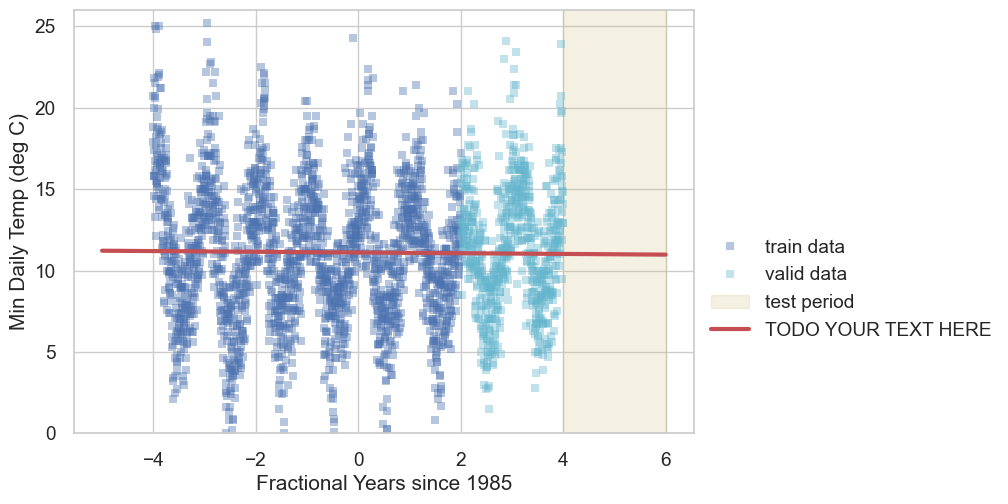

In [ ]:
plot_data_and_predictions(periodic_klr, 'TODO YOUR TEXT HERE')

## Question 9 (5 points): Compare Performance of Different Models

**Question 9 (5 points)**: In this question, you need to test the three regression models on the training, validation, and test sets and report their performances in a table. 


In [43]:
# Load the test set

data_te_df = pd.read_csv(os.path.join(DATA_DIR, 'data_test_ByYear.csv'))

x_test = data_te_df['years_since_19850101'].values[:][:,np.newaxis].copy()  # Load (T,1) feature values array
y_test = data_te_df['temp_deg_C'].values[:].copy()                           # Load (T,) feature values array

data_te_df.head()

date  years_since_19850101  temp_deg_C
0  1989-01-01                  4.00        14.3
1  1989-01-02                  4.01        17.4
2  1989-01-03                  4.01        18.5
3  1989-01-04                  4.01        16.8
4  1989-01-05                  4.01        11.5

In [39]:

# TOOD: Please test the three regression models on the training, validation, and test sets 
# and show their performances in the table below. 



pd.set_option('display.precision', 2); # please report only 2 digits of precision after decimal for RMSE
tab_df = pd.DataFrame({"method": ["linear", "RBF", "ExpSineSquared"], 
                   "train RMSE":[4.06, 4.06, 4.06], 
              "validation RMSE":[4.06, 4.06, 4.06], 
                    "test RMSE":[4.06, 4.06, 4.06]})

In [40]:
tab_df # Pretty print to this notebook

method  train RMSE  validation RMSE  test RMSE
0          linear        4.06             4.06       4.06
1             RBF        4.06             4.06       4.06
2  ExpSineSquared        4.06             4.06       4.06